# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow
tensorflow.__version__

'2.0.0'

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change current working directory to project folder (1 mark)

In [0]:
#### Add your code here ####
import matplotlib.pyplot as plt
import csv
import math
import numpy as np
from PIL import Image
from keras import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D,Reshape
from keras.utils import Sequence
from keras.backend import epsilon

import os
PATH = '/content/drive/My Drive/FaceReDetect-2/Aligned Face Dataset from Pinterest'
os.chdir(PATH)

Using TensorFlow backend.


### Extract the zip file (5 Marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [0]:
import zipfile

In [0]:
zip_file_dir = PATH+'/Aligned Face Dataset from Pinterest.zip'

In [0]:
extracted = zipfile.ZipFile(zip_file_dir, 'r')
extracted.extractall(path=PATH)

!ls

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [0]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [0]:
print(metadata.size)
print(metadata.shape)
print(metadata[5].file)

10770
(10770,)
Aaron Paul120_290.jpg


In [0]:
metadata[[0,200,1000]]

array([PINS/pins_Aaron Paul/Aaron Paul130_215.jpg,
       PINS/pins_Amanda Crew/Amanda Crew2.jpg,
       PINS/pins_Caity Lotz/Caity Lotz33.jpg], dtype=object)

In [0]:
print(metadata[200].base)
print(metadata[200].name)
print(metadata[200].file)

PINS
pins_Amanda Crew
Amanda Crew2.jpg


### Define function to load image
- Define a function to load image from the metadata

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (5 Marks)
- Load one image using the function "load_image"

In [0]:
sample_image = load_image(PATH+'/pins/PINS/pins_Alvaro Morte/Alvaro Morte109_850.jpg')

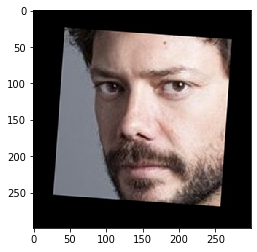

In [0]:
plt.imshow(sample_image)

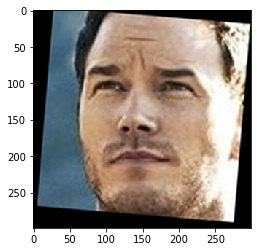

In [0]:
# Load an image
# for example, loading the image with index 1
%matplotlib inline
import matplotlib.pyplot as plt

one_image = load_image(metadata[1500].image_path())
# Show original image
# OpenCV loads images with color channels
# in BGR order. So we need to reverse them everytime we use matplotlib to show the image.
# Otherwise you see the image in false colour
plt.imshow(one_image)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (5 Marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [0]:
model = vgg_face()

In [0]:
# model = #### Add your code here ####
#### Add your code here ####

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [0]:
weight_file = 'vgg_face_weights.h5'

model.load_weights(weight_file)

### Get vgg_face_descriptor

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [0]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


-0.007891521

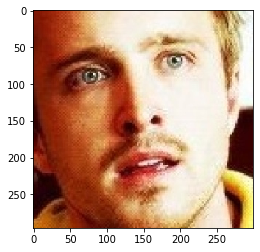

In [0]:
one_image = load_image(metadata[1].image_path())
plt.imshow(one_image)
embedding_vector[1]

### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [0]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

# for i in range(len(metadata)):
for i, m in enumerate(metadata):
  try:
    # img_path = metadata[i].image_path()
    img_path = m.image_path()
    img = load_image(img_path)
    img = (img/255.).astype(np.float32)
    img = cv2.resize(img, dsize=(224,224))

    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  except:
    print(i, m)

print(embeddings[100])

In [120]:
print(embeddings[100])

[0.01141732 0.00258387 0.0043395  ... 0.00291368 0.0004674  0.00470807]


In [121]:
embeddings[237]

array([ 0.03052757,  0.00039907, -0.00951916, ..., -0.02327576,
        0.00137858,  0.00383828])

Save Embedding Numpy Array to a Pickle File so we can import it the next time we run the code.

In [0]:
# print(type(embeddings))
# import pickle

# with open(PATH+'/embeddings.pkl','wb') as f:
#      pickle.dump(embeddings, f)

Import Pickle FIle

In [0]:
# import pickle

# with open(PATH+'/embeddings.pkl','rb') as f:
#      embeddings = pickle.load(f)
#      print(embeddings.shape)

(10770, 2622)


### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

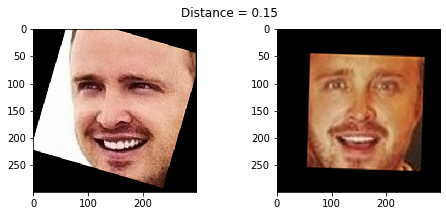

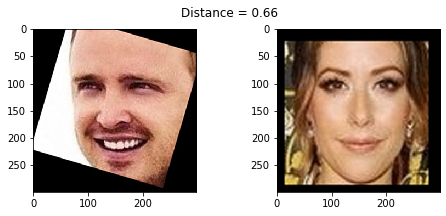

In [0]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

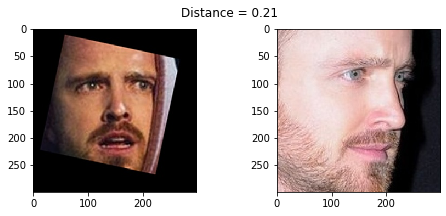

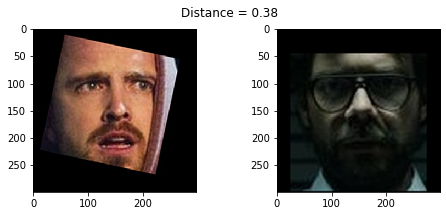

In [0]:
show_pair(30, 31)
show_pair(30, 100)

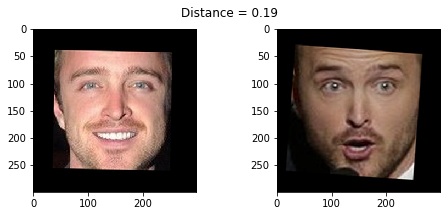

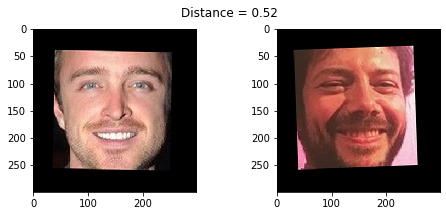

In [0]:
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [0]:
import keras
import pandas as pd

train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0
# What exactly above code is doing?

#### Add your code here ####

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]
#y_train = train_idx
#y_test = test_idx

targets = np.array([m.name for m in metadata])


y_train = targets[train_idx]
y_test = targets[test_idx]

In [0]:
print(X_train[1])
print(X_test[1])
print(y_train[1])
print(y_test[1])

[ 0.04397821 -0.00302586  0.00051129 ... -0.00943851 -0.00273483
  0.01239773]
[ 0.04952267 -0.00037868 -0.00070935 ...  0.01278188 -0.0006461
  0.00865275]
pins_Aaron Paul
pins_Aaron Paul


In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9573, 2622)
(1197, 2622)
(9573,)
(1197,)


In [0]:
y_train

array(['pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul', ...,
       'pins_zendaya', 'pins_zendaya', 'pins_zendaya'], dtype='<U29')

In [0]:
targets.shape

(10770,)

In [0]:
# one half as train examples of 10 identities


### Encode the Labels (5 marks)
- Encode the targets
- Use LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

#### Add your code here ####
le = LabelEncoder()

In [0]:
y = le.fit_transform(targets)

In [0]:
y_train1 = y[train_idx]
y_test1 = y[test_idx]

In [0]:
print(y_train1.shape)
print(y_test1.shape)

(9573,)
(1197,)


In [0]:
print(y_train[1])
print(y_test[100])

pins_Aaron Paul
pins_Bryan Cranston


In [0]:
print(y_train1[1])
print(y_test1[100])

0
9


In [0]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [0]:
svc = LinearSVC()

svc.fit(X_train, y_train1)

acc_svc = accuracy_score(y_test1, svc.predict(X_test))

print(f'SVM accuracy = {acc_svc}')

SVM accuracy = 0.9715956558061821


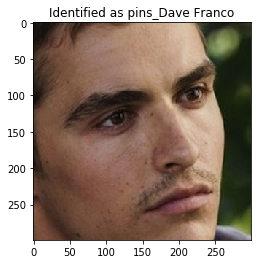

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 200

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');


**bold text**### Standardize the feature values (5 marks)
- Scale the features using StandardScaler

In [0]:
# Standarize features
from sklearn.preprocessing import StandardScaler

stds = StandardScaler()
#### Add your code here ####

In [0]:
X_train_std = stds.fit_transform(X_train)
X_test_std = stds.transform(X_test)

In [0]:
X_train_std[2]

array([ 2.40478015, -0.31526494, -0.87571275, ...,  1.34848267,
       -0.35347381, -0.75289238])

### Reduce dimensions using PCA (5 Marks)
- Reduce feature dimensions using Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA

#### Add your code here ####

In [0]:
pca1 = PCA(n_components=150)

In [0]:
pca1.fit(X_train_std)
X_train_std1 = pca1.transform(X_train_std)

X_test_std1 = pca1.transform(X_test_std)

In [0]:
print(X_train_std1.shape)
print(X_test_std1.shape)

(9573, 150)
(1197, 150)


In [0]:
from sklearn.svm import SVC

In [0]:
svc1 = SVC(C=0.01, kernel='linear')

svc1.fit(X_train_std1, y_train1)

acc_svc1 = accuracy_score(y_test1, svc1.predict(X_test_std1))

print(f'SVM accuracy = {acc_svc1}')

SVM accuracy = 0.9548872180451128


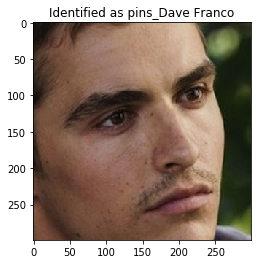

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 200
temp = [embeddings[test_idx][example_idx]]
temp = pca1.transform(temp)
example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc1.predict(temp)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

The Accuracy is more than 95% and can be considered for production use.